In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import GPy
from GPy.kern import Kern
from GPy import Param, Model

In [9]:
df = pd.read_csv('yacht_hydrodynamics.data', delim_whitespace=True,
                           names=['Long pos', 'Prismatic coeff',
                                 'Length-displacement ratio',
                                 'Beam-draught ratio',
                                 'Length-beam ratio',
                                 'Froude number',
                                 'Residuary resistance'])

In [11]:
#df = pd.read_excel('yacht_hydrodynamics.data',sep='\s+',header=None)
df.head(10)

,Long pos,Prismatic coeff,Length-displacement ratio,Beam-draught ratio,Length-beam ratio,Froude number,Residuary resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
5,-2.3,0.568,4.78,3.99,3.17,0.250,1.82
6,-2.3,0.568,4.78,3.99,3.17,0.275,2.61
7,-2.3,0.568,4.78,3.99,3.17,0.300,3.76
8,-2.3,0.568,4.78,3.99,3.17,0.325,4.99
9,-2.3,0.568,4.78,3.99,3.17,0.350,7.16


In [12]:
from sklearn.model_selection import  train_test_split

y = df['Residuary resistance'].values.reshape(-1,1)
X_df = df.copy()
X_df.drop(['Residuary resistance'], axis=1, inplace=True)
X = X_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    shuffle=True)

In [13]:
class deepRBF(Kern):
    
    def __init__(self,input_dim,variance1=1.,lengthscale=1.,variance2=1.,active_dims=None):
        super(deepRBF, self).__init__(input_dim, active_dims, 'deep_rbf')
        #assert input_dim == 1, "For this kernel we assume input_dim=1"
        self.variance1 = Param('variance1', variance1)
        self.lengthscale = Param('lengtscale', lengthscale)
        self.variance2 = Param('variance2', variance2)
        #self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.link_parameters(self.variance1, self.lengthscale, self.variance2)
    
    def parameters_changed(self):
        # nothing todo here
        pass
    
    def K(self,X,X2):
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        return self.variance2*np.power(1 + tmp2,-0.5)
    
    def Kdiag(self,X):
        return self.variance2*np.ones(X.shape[0])
    
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
            
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1

        dvar2 = np.power(1 + tmp2, -0.5)
        #dl1 = self.power * self.variance * dist2 * self.lengthscale**(-3) * (1 + dist2/2./self.power)**(-self.power-1)
        dvar1 = (-1.)*self.variance2*tmp1*np.power(1+tmp2,-1.5)
        dl = self.variance1*self.variance2*np.exp((-1.)*dist2)*dist2/self.lengthscale*np.power(1+tmp2,-1.5)
        #dp = - self.variance * np.log(1 + dist2/2.) * (1 + dist2/2.)**(-self.power)

        self.variance1.gradient = np.sum(dvar1*dL_dK)
        self.lengthscale.gradient = np.sum(dl*dL_dK)
        self.variance2.gradient = np.sum(dvar2*dL_dK)
        #self.lenthscale2.gradient = np.sum(dl2*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.variance2.gradient = np.sum(dL_dKdiag)
        # here self.lengthscale and self.power have no influence on Kdiag so target[1:] are unchanged
        
    def gradients_X(self,dL_dK,X,X2):
        """derivative of the covariance matrix with respect to X."""
        if X2 is None: X2 = X
        #dist2 = np.square((X-X2.T)/self.lengthscale)
        dist2 = (np.square(X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2
        tmp1 = 1.-np.exp((-1.)*dist2/2.)
        tmp2 = 2.*self.variance1*tmp1
        tmp3 = np.power(1+tmp2,-1.5)

        #dX = -self.variance*self.power * (X-X2.T)/self.lengthscale**2 *  (1 + dist2/2./self.lengthscale)**(-self.power-1)
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2.T)/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 *((X[:,np.newaxis]-X2).sum(axis=2))/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #dX = (-1.)*self.variance1*self.variance2 * (X-X2) / self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        #return np.sum(dL_dK*dX,1)[:,None]
        #return np.sum(dX*dL_dK,1)[:,None]
        dX_tmp = (-1.)*self.variance1*self.variance2/self.lengthscale**2 * np.exp((-1.)*dist2/2) * tmp3
        return ((dL_dK*dX_tmp)[:,:,None]*(X[:,None,:] - X2[None,:,:])).sum(1)
    
    def gradients_X_diag(self,dL_dKdiag,X):
        # no diagonal gradients
        pass
    


In [14]:
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)

In [15]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [16]:
def compute_nll(y, mf, vf):
    y = y.reshape((y.shape[0],))
    ll = -0.5 * np.log(2 * np.pi * vf) - 0.5 * (y - mf)**2 / vf
    nll = -ll
    return np.mean(nll)

## GP RBF

In [17]:
m1 = GPy.models.GPRegression(X_train, y_train)

In [18]:
m1.optimize()

In [19]:
m1f_t, m1v_t = m1.predict(X_test)

In [20]:
m1f_tr, m1v_tr = m1.predict(X_train)

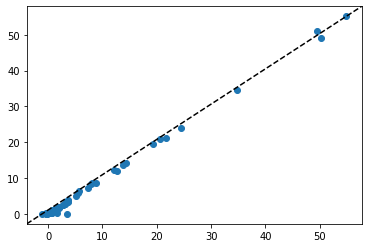

In [21]:
plt.scatter(m1f_t,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.xlim([0,55])
#plt.ylim([0,55])
plt.show()

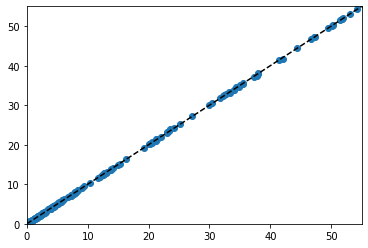

In [22]:
plt.scatter(m1f_tr,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlim([0,55])
plt.ylim([0,55])
plt.show()

## GP deep RBF

In [23]:
d_rbf = deepRBF(input_dim=X_train.shape[1])
m2 = GPy.models.GPRegression(X_train, y_train,d_rbf)

In [24]:
m2.optimize()

 /Users/luck1226/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning:invalid value encountered in power


In [25]:
m2f_t, m2v_t = m2.predict(X_test)
m2f_tr, m2v_tr = m2.predict(X_train)

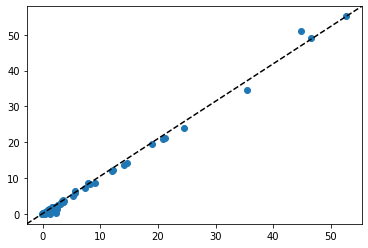

In [26]:
plt.scatter(m2f_t,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.xlim([0,55])
#plt.ylim([0,55])
plt.show()

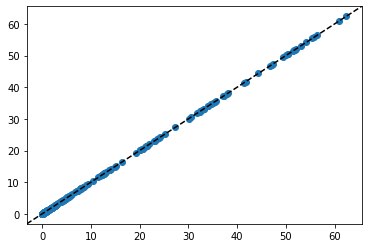

In [27]:
plt.scatter(m2f_tr,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.xlim([0,55])
#plt.ylim([0,55])
plt.show()

### Report GP RBF

In [28]:
# test error for GP RBF
print(rmse(m1f_t,y_test))

0.59907974339648


In [29]:
# Training RMSE for GP RBF
print(rmse(m1f_tr,y_train))

0.09028019082046058


In [30]:
# Test NLL
print(compute_nll(y_test,m1f_t,m1v_t))

2083.9390181612957


In [31]:
# Train NLL
print(compute_nll(y_train,m1f_tr,m1v_tr))

7150.7008297991215


### Report GP deep RBF

In [32]:
# test error for GP deep RBF
print(rmse(m2f_t,y_test))

1.0165657371263257


In [33]:
# Training RMSE for GP deepRBF
print(rmse(m2f_tr,y_train))

1.1190002884680119e-07


In [34]:
# Test NLL
print(compute_nll(y_test,m2f_t,m2v_t))

4184.935450094857


In [35]:
# Train NLL
print(compute_nll(y_train,m2f_tr,m2v_tr))

24564047193.16117


## Deep GP

In [36]:
import deepgp

In [37]:
hidden = 1
m_deep = deepgp.DeepGP([1,hidden,X_train.shape[1]],Y=y_train, X=X_train, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(hidden,ARD=True),
                           GPy.kern.RBF(X_train.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)

In [38]:
for layer in m_deep.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m_deep.optimize(messages=True,max_iters=500)

In [39]:
md, vd = m_deep.predict(X_train)
mdt, vdt = m_deep.predict(X_test)

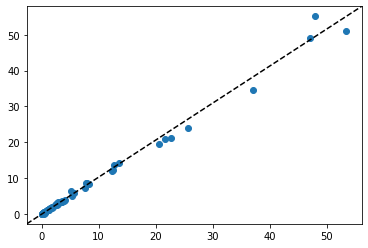

In [40]:
plt.scatter(mdt,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.xlim([0,55])
#plt.ylim([0,55])
plt.show()

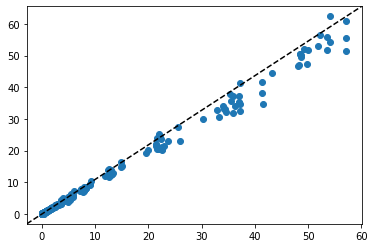

In [41]:
plt.scatter(md,y_train)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
#plt.xlim([0,55])
#plt.ylim([0,55])
plt.show()

In [42]:
print(rmse(y_test,mdt))

1.1440470386806607


In [43]:
print(rmse(y_train,md))

1.284989843927785


In [44]:
# Test NLL
print(compute_nll(y_test,mdt,vdt))

1287.1190998825857


In [45]:
# Train NLL
print(compute_nll(y_train,md,vd))

1997.9220237951554
